# PyTorch for system identification problems

## Course on Deep Learning for System Identification
## Authors: Gabriele Maroni
## Lugano, April 22th, 2024

In this tutorial, we will address a system identification problem using PyTorch, focusing on the development and training of neural networks specifically designed for input-output sequence prediction:

1. **Converting System Identification to Supervised Regression**: We'll explain how a system identification problem can be modeled as a supervised regression problem and how to use classical models, such as linear models and Feed-Forward Neural Networks (FFNNs) to solve it.

2. **Understanding Prediction Errors**: We will distinguish between one-step-ahead prediction error and simulation error, outlining their implications for model performance and training.

3. **Developing Sequence-Specific Neural Architectures**: Special focus will be placed on designing neural networks suitable for sequence problems, such as Recurrent Neural Networks (RNNs) and Long Short-Term Memory networks (LSTMs). We'll delve into the architectural choices that help capture temporal dependencies in data.

4. **Utilizing Dataset and DataLoader for Sequences**: To manage sequence data efficiently during training and minimize simulation errors, we will use PyTorch’s `Dataset` and `DataLoader` functionalities. This includes creating Datasets that fetch sequences from the original dataset and configuring DataLoaders to batch and shuffle these sequences optimally.

By the end of this tutorial, you will have a comprehensive understanding of how to implement these advanced techniques in PyTorch, crucial for solving system identification problems effectively.

In [1]:
import os
import sys
sys.path.append('..')
from src.utils import *
from src.configs import *

import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams.update(fig_params)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

%load_ext autoreload
%autoreload 2

## Global parameters

In [2]:
# Random seed value for reproducibility
SEED = 42

# Dataset path
dataset_folder = os.path.join('..', 'Datasets', 'MassSpringDamper')
dataset_path = os.path.join(dataset_folder, 'mass_spring_damper_nonlinear.pickle')

## Load dataset

<div style="display: flex; justify-content: space-between; align-items: flex-start;">
    <div style="flex: 1; padding-right: 20px;">
        The dataset that will be used in this notebook is generated simulating a nonlinear mass spring damper system.<br>
        The nonlinearity is introduced in the spring component.
        $$
        f_{spring}(x) = k x + \alpha x^3 \quad \alpha > 0 \quad \text{(hardening spring)}
        $$
        The system can be described by the following equation: 
        $$
        F - c\dot{x} - k x - \alpha x^3 = m\ddot{x}
        $$
        Rearranging the equation we get:
        $$
        \ddot{x} = \frac{1}{m}(F - c\dot{x} - k x - \alpha x^3)
        $$
        Setting $x_1 = x$, $x_2 = \dot{x}$ and $y = x_1$ we can write the system in state space form:
        \begin{align}
            \dot{x_1} &= x_2 \\
            \dot{x_2} &= \frac{1}{m}(F - c x_2 - k x_1 - \alpha x_1^3) \\
            y &= x_1
        \end{align}
    </div>
    <div style="display: flex; flex-direction: column; align-items: center; justify-content: center;">
        <div>
            <img src="images/MSD.png" width="250" height="250" alt="Nonlinear mass spring damper system">
            <div style="text-align: center;">Nonlinear mass spring damper system [1]</div>
        </div>
        <div>
            <img src="images/spring.png" width="400" height="400" alt="Spring types">
            <div style="text-align: center;">Spring types [2]</div>
        </div>
    </div>
</div>


In [3]:
df, target = load_sysid_dataset(dataset_path,
                                snr_db=35, # signal to noise ratio in dB
                                seed=SEED)

df.head()

,t,u(t),y(t)
0,0.0,0.000000,40.037819
1,0.5,1.538924,39.649408
2,1.0,2.258279,39.442578
3,1.5,2.931616,39.053522
4,2.0,2.161179,38.411349


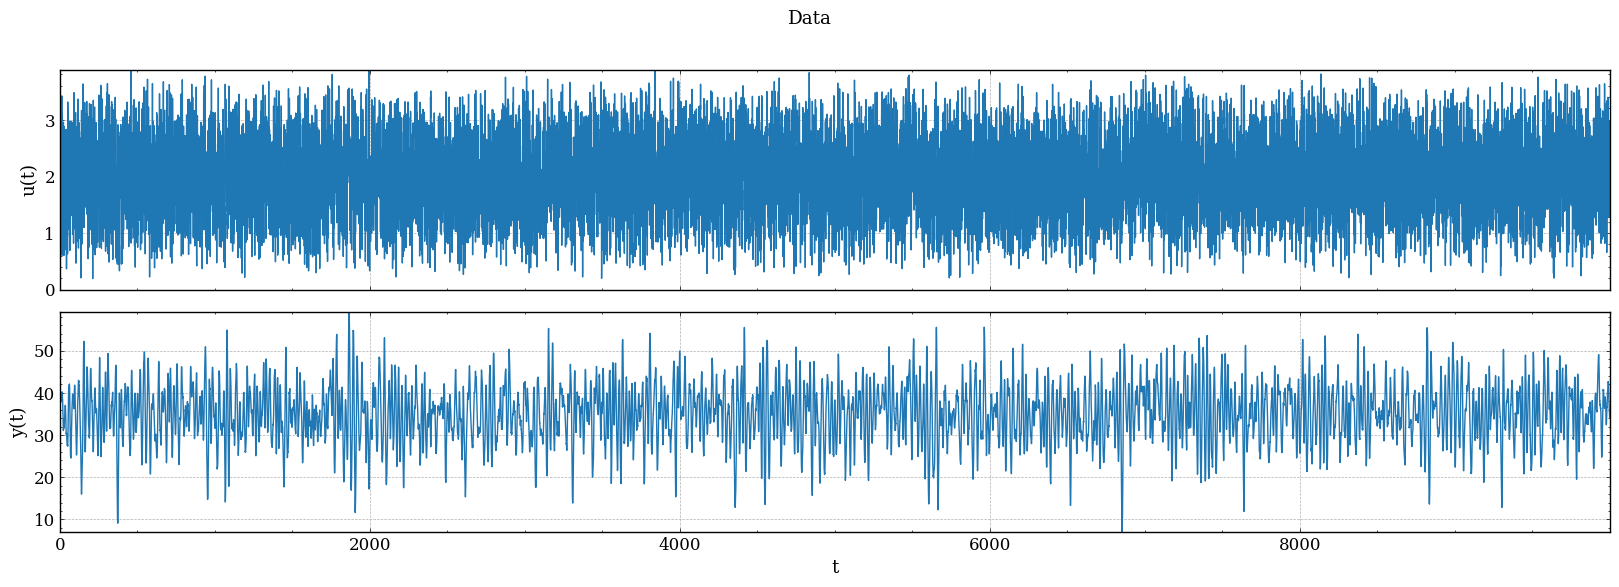

In [4]:
fig = plt.figure(figsize=(20,6))
gs = fig.add_gridspec(2, hspace=0.1)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle('Data')
axs[0].plot(df['t'], df['u(t)'], color='tab:blue')
axs[0].set_ylabel('u(t)')
axs[0].margins(0.0)

axs[1].plot(df['t'], df['y(t)'], color='tab:blue')
axs[1].set_ylabel('y(t)')
axs[1].set_xlabel('t')
axs[1].margins(0.0)

plt.show()

## Converting System Identification to Supervised Regression

In [5]:
def create_regressors(df, na, nb, dropna=True):
    t, u, y = df['t'].values, df['u(t)'].values, df['y(t)'].values
    n = y.shape[0]
    phi = pd.DataFrame(data=zip(t, u, y), index=range(n), columns=['t', 'u(t)', 'y(t)'])
    regressors = ['u(t)']
    
    for tau_b in range(1, nb+1):
        phi[f'u(t-{tau_b})'] = phi['u(t)'].shift(tau_b)
        regressors.append(f'u(t-{tau_b})')
    for tau_a in range(1, na+1):
        phi[f'y(t-{tau_a})'] = phi['y(t)'].shift(tau_a)
        regressors.append(f'y(t-{tau_a})')

    if dropna:
        phi.dropna(inplace=True)

    return phi[['t'] + regressors + ['y(t)']], regressors

The function `create_regressors` compute and organizing regressors (or features) from input-output sequence data. This function essentially prepares the dataset for regression by creating lagged versions of input ($u$) and output ($y$) variables, facilitating the modeling of temporal relationships.

In [6]:
na = 2
nb = 2

df, regressors = create_regressors(df, na=na, nb=nb, dropna=True)
df.head()

,t,u(t),u(t-1),u(t-2),y(t-1),y(t-2),y(t)
2,1.0,2.258279,1.538924,0.000000,39.649408,40.037819,39.442578
3,1.5,2.931616,2.258279,1.538924,39.442578,39.649408,39.053522
4,2.0,2.161179,2.931616,2.258279,39.053522,39.442578,38.411349
5,2.5,1.871710,2.161179,2.931616,38.411349,39.053522,38.226722
6,3.0,3.063099,1.871710,2.161179,38.226722,38.411349,38.132078


In [7]:
regressors

['u(t)', 'u(t-1)', 'u(t-2)', 'y(t-1)', 'y(t-2)']

## Train-test split

In [8]:
train, test = train_test_split(df, test_size=0.2, shuffle=False)
train.shape, test.shape

((15998, 7), (4000, 7))

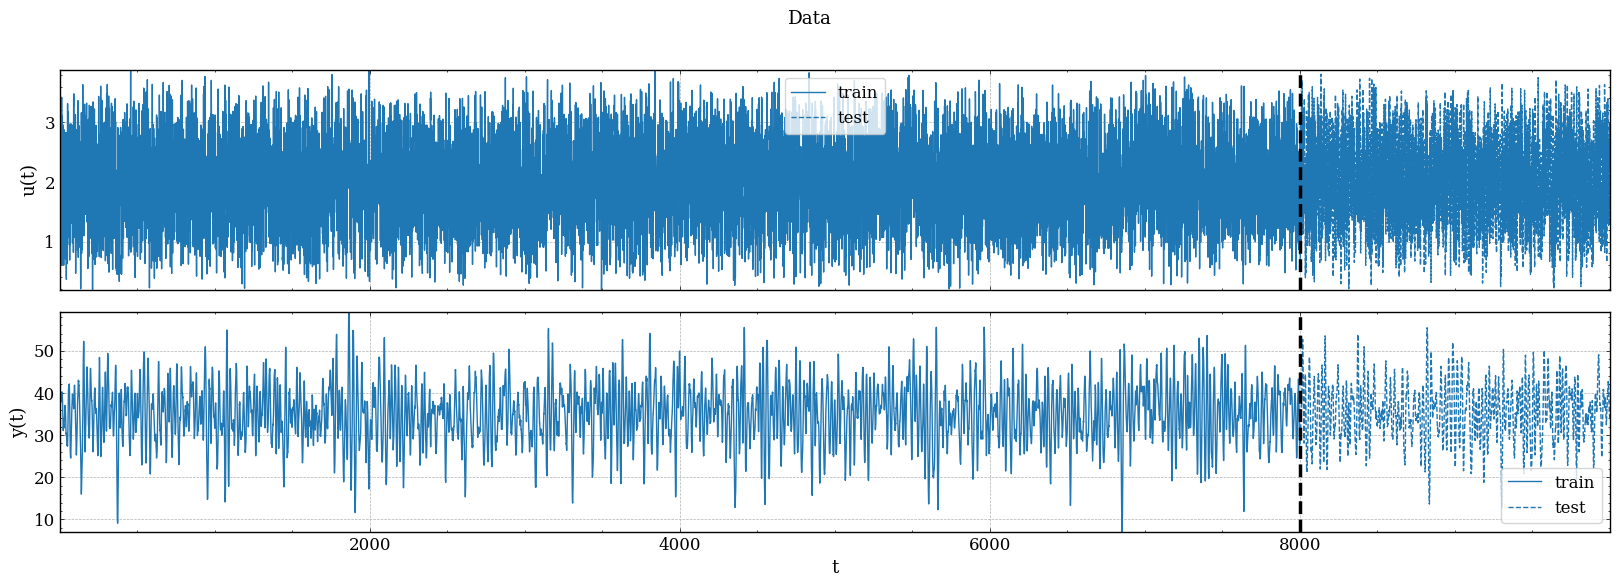

In [9]:
fig = plt.figure(figsize=(20,6))
gs = fig.add_gridspec(2, hspace=0.1)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle('Data')
axs[0].plot(train['t'], train['u(t)'], label='train', color='tab:blue')
axs[0].plot(test['t'], test['u(t)'], label='test', color='tab:blue', linestyle='--')
axs[0].axvline(train.iloc[-1]['t'], linestyle='--', color='k', linewidth=2.5)
axs[0].set_ylabel('u(t)')
axs[0].margins(0.0)
axs[0].legend()

axs[1].plot(train['t'], train['y(t)'], label='train', color='tab:blue')
axs[1].plot(test['t'], test['y(t)'], label='test', color='tab:blue', linestyle='--')
axs[1].axvline(train.iloc[-1]['t'], linestyle='--', color='k', linewidth=2.5)
axs[1].set_ylabel('y(t)')
axs[1].set_xlabel('t')
axs[1].margins(0.0)
axs[1].legend()

plt.show()

## Modeling: linear baseline

In [10]:
# Model fitting
model = LinearRegression(fit_intercept=False)
model.fit(train[regressors], train[target].values);

In [11]:
# Retrieve learned coefficients
model.coef_

array([ 0.04968208,  0.15535848,  0.07486219,  1.87461548, -0.89057912])

### Predicting and computing evaluation metrics

#### One-step ahead prediction performance

In [12]:
# Train prediction
y_pred_train = model.predict(train[regressors])
# Test prediction
y_pred_test = model.predict(test[regressors])

In [13]:
# Compute evaluation metrics on train
calculate_metrics(train[target], y_pred_train)

{'mse': 0.08370947597744614,
 'mae': 0.2305644136129095,
 'rmse': 0.2893258992510801,
 'r2': 0.9983067336678594}

In [14]:
# Compute evaluation metrics on test
calculate_metrics(test[target], y_pred_test)

{'mse': 0.0842334988128338,
 'mae': 0.2314726600922556,
 'rmse': 0.29023007909731513,
 'r2': 0.9981613157887418}

#### Simulation performance

In [15]:
# Simulate on test set
y_sim_test_linear = simulate(model, test[regressors], na=na)

In [16]:
# Compute evaluation metrics on test
calculate_metrics(test[target], y_sim_test_linear)

{'mse': 8.436016780466165,
 'mae': 2.347248501628027,
 'rmse': 2.9044821880097946,
 'r2': 0.8158550804755504}

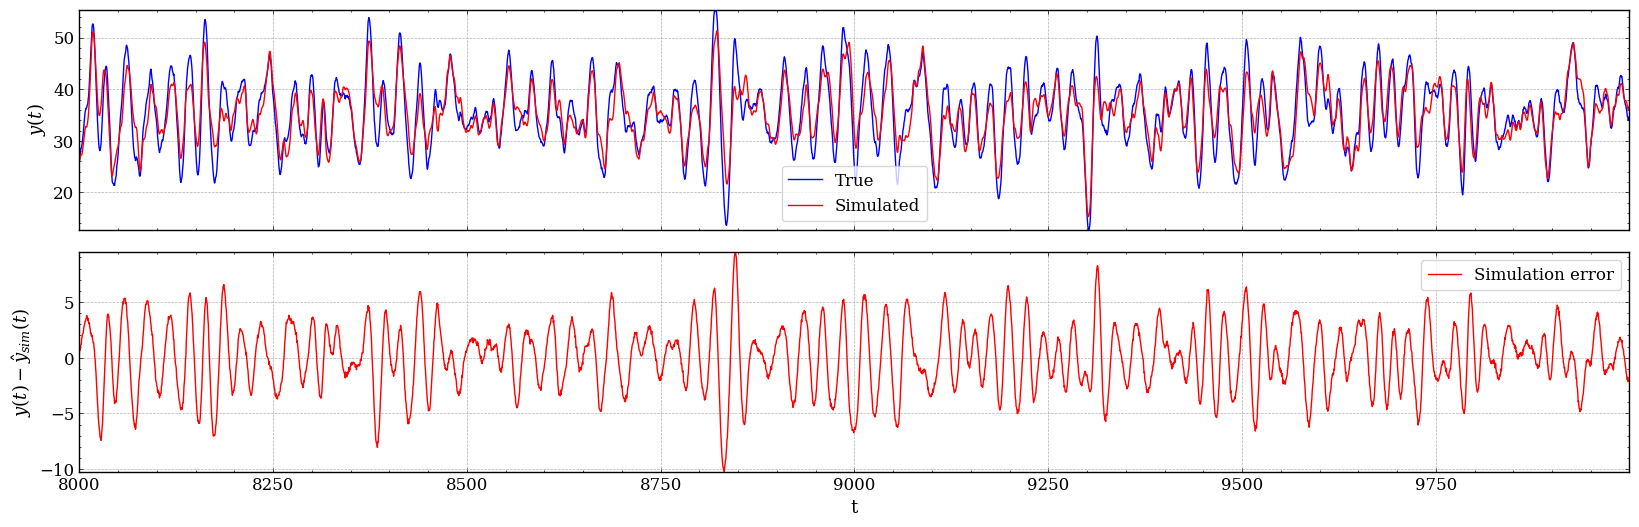

In [17]:
fig = plt.figure(figsize=(20,6))
gs = fig.add_gridspec(2, hspace=0.1)
axs = gs.subplots(sharex=True, sharey=False)

axs[0].plot(test['t'], test[target], label='True', color='b')
axs[0].plot(test['t'], y_sim_test_linear, label='Simulated', color='r', linestyle='-')
axs[0].set_ylabel(r'$y(t)$')
axs[0].margins(0.0)
axs[0].legend()

axs[1].plot(test['t'], test[target].values.reshape(-1,1) - y_sim_test_linear, label='Simulation error', color='r')
axs[1].set_ylabel(r'$y(t) - \hat{y}_{sim}(t)$')
axs[1].set_xlabel('t')
axs[1].margins(0.0)
axs[1].legend()

plt.show()

## Modeling: Feed Forward Neural Network

### Data pre-processing

In [18]:
# Normalization
x_scaler = StandardScaler()
x_train_df = pd.DataFrame(data=x_scaler.fit_transform(train[regressors]), index=train.index, columns=regressors)
x_test_df = pd.DataFrame(data=x_scaler.transform(test[regressors]), index=test.index, columns=regressors)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(train[target].values.reshape(-1,1))
y_test = y_scaler.transform(test[target].values.reshape(-1,1))

In [19]:
# Conversion to PyTorch tensors
x_train = torch.from_numpy(x_train_df.values).type(torch.Tensor)
x_test = torch.from_numpy(x_test_df.values).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [20]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FeedForwardNN, self).__init__()
        layers = []
        # Adding the first hidden layer that connects the input layer to the first hidden layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())

        # Creating subsequent hidden layers
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())

        # Adding the output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        # Wrap all layers in ModuleList so they are properly registered.
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class RegressionDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [21]:
batch_size = 128

# Datasets
train_dataset = RegressionDataset(x_train, y_train)
test_dataset = RegressionDataset(x_test, y_test)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

### Training set-up

In [22]:
seed_everything(SEED)

# Instantiate the model
model = FeedForwardNN(input_size=x_train.shape[1],
                      hidden_sizes=[20,20],
                      output_size=y_train.shape[1])
print(f"Total number of trainable model parameters: {get_model_num_params(model)}")

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define loss function
loss_function = nn.MSELoss()

# Calculate loss value with untrained model to use as reference
y_pred_train = model(x_train)
loss0 = loss_function(y_pred_train, y_train).item()
print(f"Initial loss: {loss0:.5f}")

Total number of trainable model parameters: 561
Initial loss: 1.05094


### Training loop

In [23]:
# Number of epochs
epochs = 1000

# Training loop
for epoch in range(epochs):
    # Training
    loss = 0.0
    for x_train_batch, y_train_batch in train_loader:
        optimizer.zero_grad()
        y_pred_train_batch = model(x_train_batch)
        loss_batch = loss_function(y_pred_train_batch, y_train_batch)
        loss_batch.backward()
        optimizer.step()
        loss += loss_batch.item() * x_train_batch.size(0)

    # Average loss
    loss /= train.shape[0]

    # Logging
    if epoch % 100 == 0:
        print(f"Epoch: {epoch:03d}/{epochs:03d}"
              f" | Train Loss: {loss:.6f}")

Epoch: 000/1000 | Train Loss: 1.011835
Epoch: 100/1000 | Train Loss: 0.001975
Epoch: 200/1000 | Train Loss: 0.001706
Epoch: 300/1000 | Train Loss: 0.001681
Epoch: 400/1000 | Train Loss: 0.001674
Epoch: 500/1000 | Train Loss: 0.001670
Epoch: 600/1000 | Train Loss: 0.001669
Epoch: 700/1000 | Train Loss: 0.001666
Epoch: 800/1000 | Train Loss: 0.001664
Epoch: 900/1000 | Train Loss: 0.001663


### Predicting and computing evaluation metrics

#### One-step ahead prediction performance

In [24]:
with torch.no_grad():
    # Train prediction
    y_pred_train = model(x_train)
    # Test prediction
    y_pred_test = model(x_test)
    
    # Invert scaling operation
    y_pred_train = y_scaler.inverse_transform(y_pred_train.numpy())
    y_pred_test = y_scaler.inverse_transform(y_pred_test.numpy())

In [25]:
# Compute evaluation metrics on train
calculate_metrics(train[target], y_pred_train)

{'mse': 0.08288587156937428,
 'mae': 0.2293595253272251,
 'rmse': 0.287899064898402,
 'r2': 0.9983233934497886}

In [26]:
# Compute evaluation metrics on test
calculate_metrics(test[target], y_pred_test)

{'mse': 0.08513483912099892,
 'mae': 0.23266014402480567,
 'rmse': 0.2917787502903509,
 'r2': 0.9981416409537065}

#### Simulation performance

In [27]:
# Simulate on test set
y_sim_test_ffnn = simulate(model, x_test_df, na=2, torch_model=True)
y_sim_test_ffnn = y_scaler.inverse_transform(y_sim_test_ffnn)

In [28]:
# Compute evaluation metrics on test
calculate_metrics(test[target], y_sim_test_ffnn)

{'mse': 7.330101037378682,
 'mae': 2.176509000785039,
 'rmse': 2.7074159335755343,
 'r2': 0.8399954740773296}

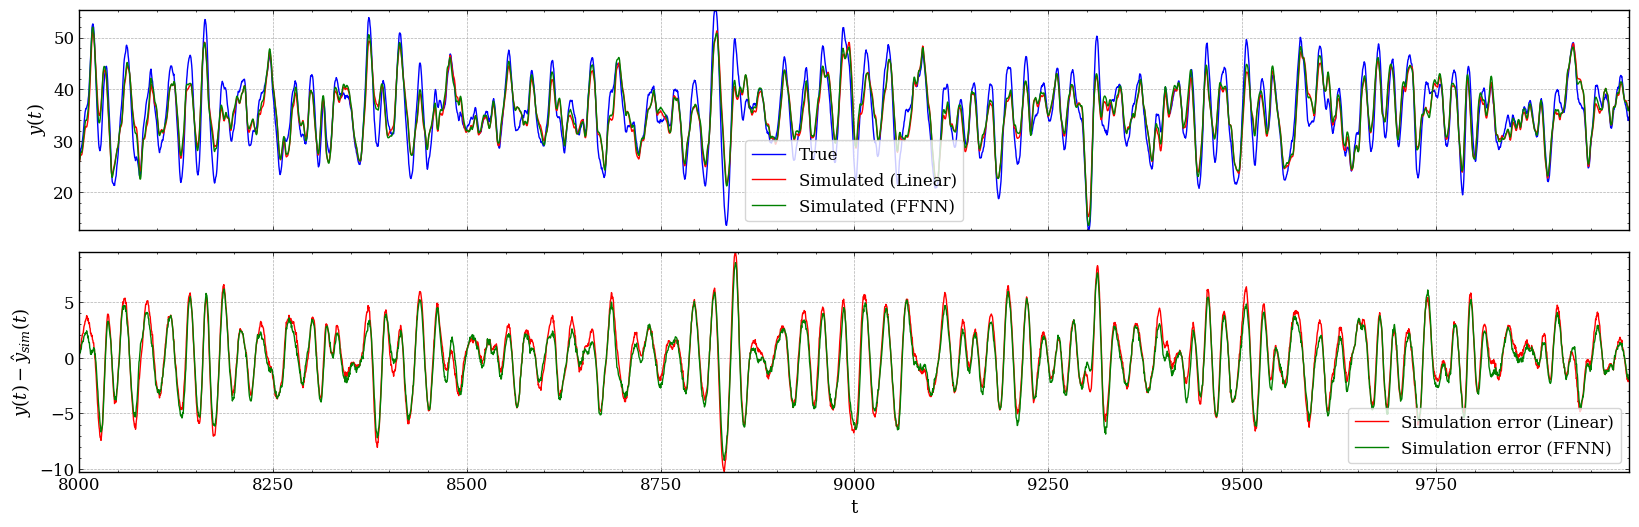

In [29]:
fig = plt.figure(figsize=(20,6))
gs = fig.add_gridspec(2, hspace=0.1)
axs = gs.subplots(sharex=True, sharey=False)

axs[0].plot(test['t'], test[target], label='True', color='b')
axs[0].plot(test['t'], y_sim_test_linear, label='Simulated (Linear)', color='r', linestyle='-')
axs[0].plot(test['t'], y_sim_test_ffnn, label='Simulated (FFNN)', color='g', linestyle='-')
axs[0].set_ylabel(r'$y(t)$')
axs[0].margins(0.0)
axs[0].legend()

axs[1].plot(test['t'], test[target].values.reshape(-1,1) - y_sim_test_linear, label='Simulation error (Linear)', color='r')
axs[1].plot(test['t'], test[target].values.reshape(-1,1) - y_sim_test_ffnn, label='Simulation error (FFNN)', color='g')
axs[1].set_ylabel(r'$y(t) - \hat{y}_{sim}(t)$')
axs[1].set_xlabel('t')
axs[1].margins(0.0)
axs[1].legend()

plt.show()

## Modeling: Recurrent Neural Network

In [30]:
class SystemIdentificationDataset(Dataset):
    def __init__(self, input_data, output_data, sequence_length):
        self.input_data = input_data
        self.output_data = output_data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.input_data) - self.sequence_length + 1

    def __getitem__(self, idx):
        return (self.input_data[idx:idx+self.sequence_length],
                self.output_data[idx:idx+self.sequence_length])

class SystemIdentificationDataset(Dataset):
    def __init__(self, input_data, output_data, sequence_length):
        self.input_data = input_data
        self.output_data = output_data
        self.sequence_length = sequence_length

    def __len__(self):
        # Calculate how many non-overlapping sequences fit into the dataset
        return (len(self.input_data) // self.sequence_length)

    def __getitem__(self, idx):
        # Calculate the start index of the sequence
        start_idx = idx * self.sequence_length
        # Return the non-overlapping sequence
        return (self.input_data[start_idx:start_idx + self.sequence_length],
                self.output_data[start_idx:start_idx + self.sequence_length])

In [31]:
# Normalization
u_scaler = StandardScaler()
u_train = u_scaler.fit_transform(train['u(t)'].values.reshape(-1,1))
u_test = u_scaler.transform(test['u(t)'].values.reshape(-1,1))

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(train[target].values.reshape(-1,1))
y_test = y_scaler.transform(test[target].values.reshape(-1,1))

In [32]:
# Conversion to PyTorch tensors
u_train = torch.from_numpy(u_train).type(torch.Tensor)
u_test = torch.from_numpy(u_test).type(torch.Tensor)

y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [33]:
batch_size = 159
sequence_length = 100

# Datasets
train_dataset = SystemIdentificationDataset(u_train, y_train, sequence_length=sequence_length)
test_dataset = SystemIdentificationDataset(u_test, y_test, sequence_length=sequence_length)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [34]:
len(train_dataset)

159

In [35]:
for u_train_batch, y_train_batch in train_loader:
    break

In [36]:
u_train_batch.shape

torch.Size([159, 100, 1])

In [37]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # Stack multiple RNN layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Forward propagate the RNN
        h, _ = self.rnn(x, h0)
        
        # Return all the output sequence
        y = self.fc(h)
        return y

#### RNN
- **Purpose**: A sequential model designed to handle input-output sequence data, featuring multiple stacked RNN layers.
- **Initialization** (`__init__`):
  - **`input_size`**: Specifies the number of features in the input data. Each feature is processed at each time step.
  - **`hidden_size`**: The number of features in the hidden state of each RNN layer.
  - **`output_size`**: Number of neurons in the output layer, determining the dimensionality of the output.
  - **`num_layers`**: Indicates how many stacked RNN layers are used in the model.
  - **Layers**:
    - **`self.rnn`**: An RNN layer that stacks `num_layers` of RNN cells. The parameter `batch_first=True` indicates that the input tensors are expected to have a batch dimension first.
    - **`self.fc`**: A fully connected (linear) layer that maps the output of the RNN layers to the final output size.
- **Forward Pass** (`forward`):
  - **Hidden State Initialization**: Starts with initializing the hidden state `h0` to zeros. This tensor has dimensions (`num_layers`, `batch_size`, `hidden_size`).
  - **Forward Propagation in RNN**: The input `x` along with the initial hidden state `h0` are passed through the RNN layers. The RNN outputs a new hidden state `h` and a temporary hidden state.
  - **Output Generation**: The hidden states `h` from the last RNN layer are then passed through the fully connected layer `self.fc`, which projects them to the desired `output_size`. The result is `y`, representing the output sequence where each time step's hidden state is transformed to an output vector.
  - **Return Values**: The function returns `y`, which is the sequence of outputs corresponding to each time step.

### Training set-up

In [38]:
seed_everything(SEED)

# Instantiate the model
model = RNN(input_size=u_train.shape[1],
            hidden_size=20,
            output_size=y_train.shape[1],
            num_layers=2)
print(f"Total number of trainable model parameters: {get_model_num_params(model)}")

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define loss function
loss_function = nn.MSELoss()

Total number of trainable model parameters: 1321


### Training loop

In [39]:
# Number of epochs
epochs = 5000

# Training loop
for epoch in range(epochs):
    # Training
    loss = 0.0
    for u_train_batch, y_train_batch in train_loader:
        optimizer.zero_grad()
        y_pred_train_batch = model(u_train_batch)
        loss_batch = loss_function(y_pred_train_batch, y_train_batch)
        loss_batch.backward()
        optimizer.step()
        loss += loss_batch.item() * x_train_batch.size(0)

    # Average loss
    loss /= train.shape[0]

    # Logging
    if epoch % 100 == 0:
        print(f"Epoch: {epoch:03d}/{epochs:03d}"
              f" | Train Loss: {loss:.6f}")

Epoch: 000/5000 | Train Loss: 0.008068
Epoch: 100/5000 | Train Loss: 0.007675
Epoch: 200/5000 | Train Loss: 0.004573
Epoch: 300/5000 | Train Loss: 0.004061
Epoch: 400/5000 | Train Loss: 0.003812
Epoch: 500/5000 | Train Loss: 0.003546
Epoch: 600/5000 | Train Loss: 0.002498
Epoch: 700/5000 | Train Loss: 0.002245
Epoch: 800/5000 | Train Loss: 0.002149
Epoch: 900/5000 | Train Loss: 0.002089
Epoch: 1000/5000 | Train Loss: 0.002051
Epoch: 1100/5000 | Train Loss: 0.002025
Epoch: 1200/5000 | Train Loss: 0.002006
Epoch: 1300/5000 | Train Loss: 0.001992
Epoch: 1400/5000 | Train Loss: 0.001981
Epoch: 1500/5000 | Train Loss: 0.001972
Epoch: 1600/5000 | Train Loss: 0.001964
Epoch: 1700/5000 | Train Loss: 0.001958
Epoch: 1800/5000 | Train Loss: 0.001952
Epoch: 1900/5000 | Train Loss: 0.001948
Epoch: 2000/5000 | Train Loss: 0.001944
Epoch: 2100/5000 | Train Loss: 0.001940
Epoch: 2200/5000 | Train Loss: 0.001937
Epoch: 2300/5000 | Train Loss: 0.001935
Epoch: 2400/5000 | Train Loss: 0.001932
Epoch: 250

### Predicting and computing evaluation metrics

#### Simulation performance

In [40]:
with torch.no_grad():
    y_sim_test_rnn = model(u_test.unsqueeze(0))

y_sim_test_rnn = y_scaler.inverse_transform(y_sim_test_rnn.numpy().squeeze(0))

In [41]:
calculate_metrics(test[target], y_sim_test_rnn)

{'mse': 0.40755835929818496,
 'mae': 0.35240734220274567,
 'rmse': 0.6384029756338742,
 'r2': 0.991103644856627}

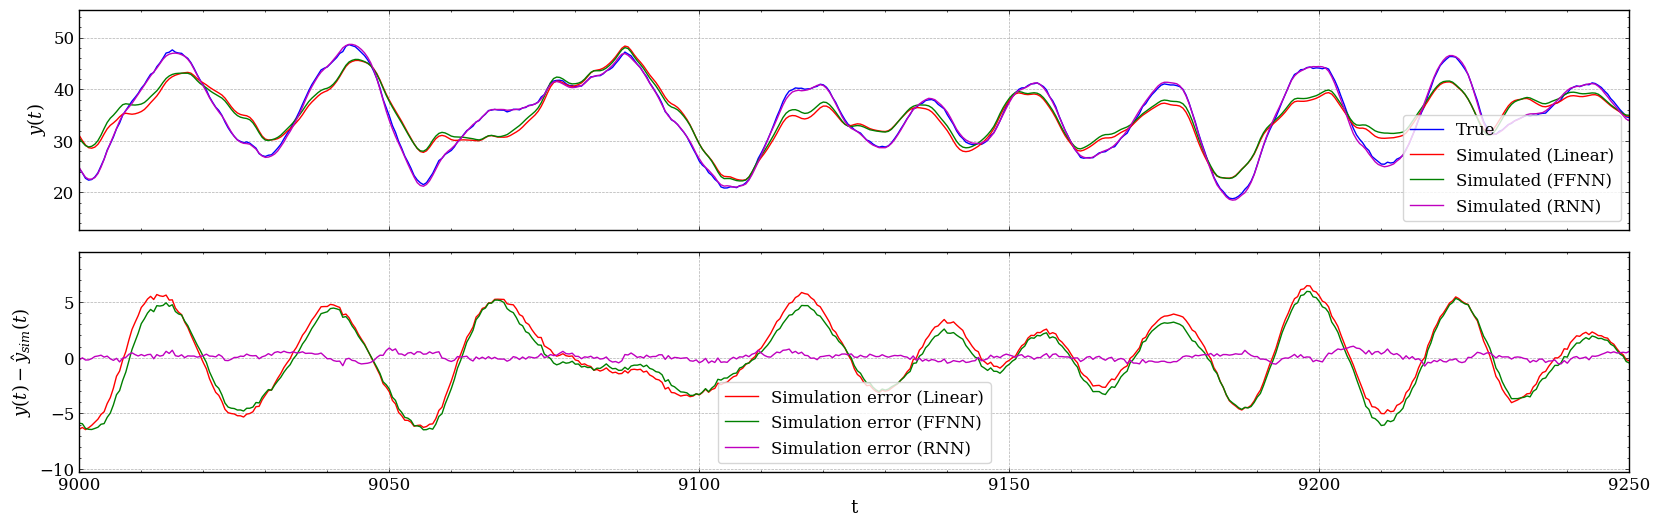

In [42]:
fig = plt.figure(figsize=(20,6))
gs = fig.add_gridspec(2, hspace=0.1)
axs = gs.subplots(sharex=True, sharey=False)

axs[0].plot(test['t'], test[target], label='True', color='b')
axs[0].plot(test['t'], y_sim_test_linear, label='Simulated (Linear)', color='r', linestyle='-')
axs[0].plot(test['t'], y_sim_test_ffnn, label='Simulated (FFNN)', color='g', linestyle='-')
axs[0].plot(test['t'], y_sim_test_rnn, label='Simulated (RNN)', color='m', linestyle='-')
axs[0].set_ylabel(r'$y(t)$')
axs[0].margins(0.0)
axs[0].legend()

axs[1].plot(test['t'], test[target].values.reshape(-1,1) - y_sim_test_linear, label='Simulation error (Linear)', color='r')
axs[1].plot(test['t'], test[target].values.reshape(-1,1) - y_sim_test_ffnn, label='Simulation error (FFNN)', color='g')
axs[1].plot(test['t'], test[target].values.reshape(-1,1) - y_sim_test_rnn, label='Simulation error (RNN)', color='m')
axs[1].set_ylabel(r'$y(t) - \hat{y}_{sim}(t)$')
axs[1].set_xlabel('t')
axs[1].margins(0.0)
axs[1].legend()

plt.xlim(9000,9250)
plt.show()

## Modeling: LSTM

In [43]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define the output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        # (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # h_n, c_n: tensors of shape (num_layers, batch_size, hidden_size)
        out, (h_n, c_n) = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        y = self.fc(out)
        return y

In [44]:
seed_everything(SEED)

# Instantiate the model
model = LSTM(input_size=u_train.shape[1],
            hidden_size=20,
            output_size=y_train.shape[1],
            num_layers=2)
print(f"Total number of trainable model parameters: {get_model_num_params(model)}")

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define loss function
loss_function = nn.MSELoss()

Total number of trainable model parameters: 5221


In [45]:
# Number of epochs
epochs = 5000

# Training loop
for epoch in range(epochs):
    # Training
    loss = 0.0
    for u_train_batch, y_train_batch in train_loader:
        optimizer.zero_grad()
        y_pred_train_batch = model(u_train_batch)
        loss_batch = loss_function(y_pred_train_batch, y_train_batch)
        loss_batch.backward()
        optimizer.step()
        loss += loss_batch.item() * x_train_batch.size(0)

    # Average loss
    loss /= train.shape[0]

    # Logging
    if epoch % 100 == 0:
        print(f"Epoch: {epoch:03d}/{epochs:03d}"
              f" | Train Loss: {loss:.6f}")

Epoch: 000/5000 | Train Loss: 0.008302
Epoch: 100/5000 | Train Loss: 0.003533
Epoch: 200/5000 | Train Loss: 0.001916
Epoch: 300/5000 | Train Loss: 0.001875
Epoch: 400/5000 | Train Loss: 0.001865
Epoch: 500/5000 | Train Loss: 0.001872
Epoch: 600/5000 | Train Loss: 0.001830
Epoch: 700/5000 | Train Loss: 0.001816
Epoch: 800/5000 | Train Loss: 0.001801
Epoch: 900/5000 | Train Loss: 0.001785
Epoch: 1000/5000 | Train Loss: 0.001826
Epoch: 1100/5000 | Train Loss: 0.001753
Epoch: 1200/5000 | Train Loss: 0.001754
Epoch: 1300/5000 | Train Loss: 0.001718
Epoch: 1400/5000 | Train Loss: 0.001692
Epoch: 1500/5000 | Train Loss: 0.001663
Epoch: 1600/5000 | Train Loss: 0.001625
Epoch: 1700/5000 | Train Loss: 0.001597
Epoch: 1800/5000 | Train Loss: 0.001564
Epoch: 1900/5000 | Train Loss: 0.001535
Epoch: 2000/5000 | Train Loss: 0.001512
Epoch: 2100/5000 | Train Loss: 0.001476
Epoch: 2200/5000 | Train Loss: 0.001451
Epoch: 2300/5000 | Train Loss: 0.001419
Epoch: 2400/5000 | Train Loss: 0.001985
Epoch: 250

In [46]:
with torch.no_grad():
    y_sim_test_lstm  = model(u_test.unsqueeze(0))

y_sim_test_lstm = y_scaler.inverse_transform(y_sim_test_lstm.numpy().squeeze(0))

In [47]:
calculate_metrics(test[target], y_sim_test_lstm)

{'mse': 0.8969212250952766,
 'mae': 0.582415993343501,
 'rmse': 0.9470592511006249,
 'r2': 0.9804216265670096}

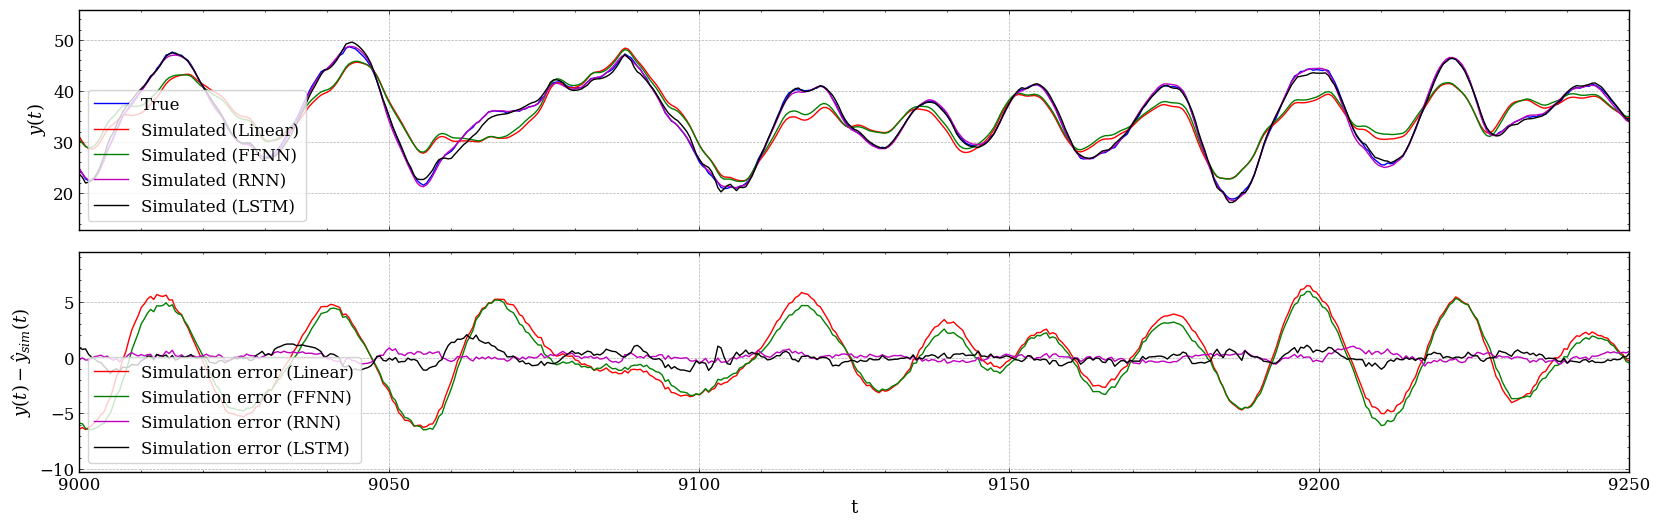

In [50]:
fig = plt.figure(figsize=(20,6))
gs = fig.add_gridspec(2, hspace=0.1)
axs = gs.subplots(sharex=True, sharey=False)

axs[0].plot(test['t'], test[target], label='True', color='b')
axs[0].plot(test['t'], y_sim_test_linear, label='Simulated (Linear)', color='r', linestyle='-')
axs[0].plot(test['t'], y_sim_test_ffnn, label='Simulated (FFNN)', color='g', linestyle='-')
axs[0].plot(test['t'], y_sim_test_rnn, label='Simulated (RNN)', color='m', linestyle='-')
axs[0].plot(test['t'], y_sim_test_lstm, label='Simulated (LSTM)', color='k', linestyle='-')
axs[0].set_ylabel(r'$y(t)$')
axs[0].margins(0.0)
axs[0].legend()

axs[1].plot(test['t'], test[target].values.reshape(-1,1) - y_sim_test_linear, label='Simulation error (Linear)', color='r')
axs[1].plot(test['t'], test[target].values.reshape(-1,1) - y_sim_test_ffnn, label='Simulation error (FFNN)', color='g')
axs[1].plot(test['t'], test[target].values.reshape(-1,1) - y_sim_test_rnn, label='Simulation error (RNN)', color='m')
axs[1].plot(test['t'], test[target].values.reshape(-1,1) - y_sim_test_lstm, label='Simulation error (LSTM)', color='k')
axs[1].set_ylabel(r'$y(t) - \hat{y}_{sim}(t)$')
axs[1].set_xlabel('t')
axs[1].margins(0.0)
axs[1].legend()

plt.xlim(9000,9250)
plt.show()

## References

- [1] https://www.halvorsen.blog/documents/programming/python/resources/powerpoints/Mass-Spring-Damper%20System%20with%20Python.pdf

- [2] https://manojsrinivasan.org/Courses/ME8230NonlinearDynamics_Sp2016/LectureNotes/L14_ForcedNonlinearSystemsPhenomena.pdf